# Anomaly detection using LSTM

**Malhotra, Pankaj**, ***et al***. **"LSTM-based encoder-decoder for multi-sensor anomaly detection."** arXiv preprint arXiv:1607.00148 (2016).

* Recurrent auto-encoder ( a kind of Seq2Seq model) 
* Reconstruction error is used as an indicator of anomaly score 

## 1. Preprocess data
* Download **'train.npy'**, and **'test.npy'**  

>* https://github.com/YongHoYoo/anomaly_tutorial/blob/master/train.npy
>* https://github.com/YongHoYoo/anomaly_tutorial/blob/master/test.npy

* Move the downloaded files into current directory

In [3]:
!git clone https://github.com/YongHoYoo/anomaly_tutorial.git
 

Cloning into 'anomaly_tutorial'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [0]:
import torch
import numpy as np
import pickle 

# training data
all_data = torch.tensor(np.load('anomaly_tutorial/train.npy')).float()
	
train_data = all_data[:, :-1] 
train_label = all_data[:, -1] 

mean = train_data.mean(dim=0) 
std = train_data.std(dim=0) 

train_data = (train_data-mean)/std

# test data 
all_data = torch.tensor(np.load('anomaly_tutorial/test.npy')).float()
test_data = all_data[:, :-1] 
test_label = all_data[:, -1] 

test_data = (test_data-mean)/std 

* Normalize train data and test data 


* Display the training data and data data
>* train_data, test data: **(seq_len)** by **(num_feature)** 
>* train_label, test_label: **(seq_len)**


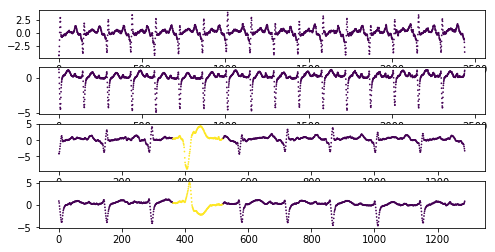

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,4)) 
ax1 = fig.add_subplot(4, 1, 1) 
ax2 = fig.add_subplot(4, 1, 2) 
ax3 = fig.add_subplot(4, 1, 3) 
ax4 = fig.add_subplot(4, 1, 4) 

ax1.scatter(torch.arange(len(train_data)), train_data[:,0], c=train_label, s=0.5) 
ax2.scatter(torch.arange(len(train_data)), train_data[:,1], c=train_label, s=0.5) 
ax3.scatter(torch.arange(len(test_data)), test_data[:,0], c=test_label, s=0.5) 
ax4.scatter(torch.arange(len(test_data)), test_data[:,1], c=test_label, s=0.5) 

* batchify for training and evaluation

In [0]:
def batchify(data, window_size): 
  n_window = data.size(0) // window_size
  batched_data = data[:n_window*window_size].view(n_window, window_size, -1).contiguous()
  return batched_data


In [0]:
train_data = batchify(train_data, 64)
train_label = batchify(train_label, 64) 

test_data = batchify(test_data, 64)
test_label = batchify(test_label, 64) 

 
## 2. Define model

### 1) LSTM Cell 

<img src="https://raw.githubusercontent.com/YongHoYoo/AnomalyDetection/master/RAE1.png" width="320">



* $i_t = \sigma(W_ix_t + U_i h_{t-1})$
* $f_t = \sigma(W_fx_t + U_f h_{t-1})$
* $o_t = \sigma(W_ox_t + U_o h_{t-1})$
* $c_t = f_t\cdot  c_{t-1} + i_t \cdot tanh (W_c x_t + U_c h_{t-1})$
* $h_t = o_t \cdot tanh (c_t) $

In [0]:
import torch

class LSTMCell(torch.nn.Module): 
  def __init__(self, ninp, nhid): 
    super(LSTMCell, self).__init__()
    self.ninp = ninp 
    self.nhid = nhid 	

    self.i2h = torch.nn.Linear(ninp, 4*nhid)
    self.h2h = torch.nn.Linear(nhid, 4*nhid) 

  def forward(self, input, hidden=None): 

    batch_size = input.size(0) 
	
    if hidden is None: 
      hx = torch.zeros(batch_size, self.nhid)
      cx = torch.zeros(batch_size, self.nhid) 
    else:
      hx, cx = hidden
    
    gates = self.i2h(input) + self.h2h(hx)
		
    ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1) 
		
    ingate = torch.nn.Sigmoid()(ingate) 
    forgetgate = torch.nn.Sigmoid()(forgetgate) 
    cellgate = torch.nn.Tanh()(cellgate) 
    outgate = torch.nn.Sigmoid()(outgate) 

    cy = (forgetgate * cx) + (ingate * cellgate) 
    hy = outgate * torch.nn.Tanh()(cy) 

    return hy, cy 

### 2) StackedLSTM Cell 

<img src="https://raw.githubusercontent.com/YongHoYoo/AnomalyDetection/master/RAE2.png" width="320">


* Stack LSTMCell

In [0]:
class StackedLSTMCell(torch.nn.Module):
  def __init__(self, nhid, nlayer):
    super(StackedLSTMCell, self).__init__()
    self.nhid = nhid
    self.nlayer = nlayer

    lstm = []
 
    for l in range(nlayer):
      lstm.append(LSTMCell(nhid, nhid))

      self.lstm = torch.nn.ModuleList(lstm)
 
  def forward(self, input, hiddens=None):
    
    if hiddens is None: 
      hiddens = [None for l in range(self.nlayer)] 
      
    new_hiddens = []
       
    
    for l in range(self.nlayer):
      hy, cy = self.lstm[l](input, hiddens[l])
      new_hiddens.append((hy,cy))
 
      input = hy
    return input, new_hiddens
 


### 3) Encoder 

<img src="https://raw.githubusercontent.com/YongHoYoo/AnomalyDetection/master/RAE3.png" width="320">

* Linear layer 
* Stacked LSTMCell

In [0]:

class Encoder(torch.nn.Module):
  def __init__(self, ninp, nhid, nlayer):
 
    super(Encoder, self).__init__()
    self.nhid = nhid
    self.nlayer = nlayer
    self.input_layer = torch.nn.Linear(ninp, nhid)
    self.stack_lstm = StackedLSTMCell(nhid, nlayer)
 
  def forward(self, inputs, hiddens=None):
    # inputs: batch by time by feature
    timestep = inputs.size(1)
    outputs = []
    
    for t in range(timestep):
      output = self.input_layer(inputs[:, t]) 
      output, hiddens = self.stack_lstm(output, hiddens)
      outputs.append(output)


    outputs = torch.stack(outputs, 1)
 
    return outputs, hiddens


### 4) Decoder

<img src="https://raw.githubusercontent.com/YongHoYoo/AnomalyDetection/master/RAE4.png" width="320">

* Linear layer (input)
* StackedLSTMCell
* Linear layer (output)





In [0]:
class Decoder(torch.nn.Module):
  def __init__(self, ninp, nhid, nlayer):
 
    super(Decoder, self).__init__()
    self.nhid = nhid
    self.nlayer = nlayer
    self.input_layer = torch.nn.Linear(ninp, nhid)
    self.stack_lstm = StackedLSTMCell(nhid, nlayer)
    self.output_layer = torch.nn.Linear(nhid, ninp) 
 
  def forward(self, hiddens, timestep): 
    
    outputs = [self.output_layer(hiddens[-1][0])]    
    
    for t in range(timestep-1): 
      
      output = self.input_layer(outputs[-1]) 
      output, hiddens = self.stack_lstm(output, hiddens)
      output = self.output_layer(hiddens[-1][0]) 
      outputs.append(output)

    outputs = torch.stack(outputs, 1)
 
    return outputs


### 5) Encoder-Decoder

<img src="https://raw.githubusercontent.com/YongHoYoo/AnomalyDetection/master/RAE5.png" width="320">

In [0]:
class EncoderDecoder(torch.nn.Module):
  def __init__(self, ninp, nhid, nlayer): 
    super(EncoderDecoder, self).__init__() 

    self.ninp = ninp 
    self.nhid = nhid 
    self.nlayer = nlayer 
    
    self.encoder = Encoder(ninp, nhid, nlayer) 
    self.decoder = Decoder(ninp, nhid, nlayer) 
    
  def forward(self, inputs): 
    
    timestep = inputs.size(1)    
    outputs, hiddens = self.encoder(inputs)
    outputs = self.decoder(hiddens, timestep)
    
    return outputs
    
    
    
    

## 3. Train data

In [0]:
model = EncoderDecoder(2, 64, 2)

Data loader

In [0]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset): 
  def __init__(self, x, y):
    self.x = x
    self.y = y 
    
  def __getitem__(self, index): 
    return self.x[index], self.y[index] 
  
  def __len__(self):
    return len(self.x) 
  
train_dataset = MyDataset(train_data, train_label) 
test_dataset = MyDataset(test_data, test_label) 
  
train_loader = DataLoader(dataset=train_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

Epoch:  9 7.548222005367279
Epoch:  19 6.581120103597641
Epoch:  29 6.661361277103424
Epoch:  39 5.290386319160461
Epoch:  49 6.399227887392044
Epoch:  59 5.080422282218933
Epoch:  69 2.718517392873764
Epoch:  79 3.536568783223629
Epoch:  89 2.5334849059581757
Epoch:  99 2.018225610256195


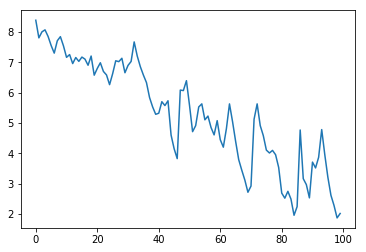

In [21]:
num_epochs = 100

loss = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters()) 

total_error = [] 
for epochs in range(num_epochs): 
  
  epoch_error = 0 
  for inputs, _ in train_loader: 
    
    optimizer.zero_grad() 
    outputs = model(inputs) 
    error = loss(outputs.squeeze(), inputs) 
    error.backward() 
    optimizer.step() 
    
    epoch_error+=error.item() 

  if (epochs+1)%10==0: 
    print('Epoch: ', epochs, epoch_error) 
  
  total_error.append(epoch_error)
  
plt.plot(total_error) 

## 4. Evaluate data

In [0]:
disp_inputs = [] 
disp_outputs = [] 
disp_labels = [] 

model.eval() 

for inputs, labels in test_loader: 
  outputs = model(inputs) 
  
  disp_inputs.append(inputs.squeeze())
  disp_outputs.append(outputs.squeeze()) 
  
  disp_labels.append(labels.squeeze()) 
  
disp_inputs = torch.cat(disp_inputs, 0) 
disp_outputs = torch.cat(disp_outputs, 0).detach() 
disp_labels = torch.cat(disp_labels, 0)

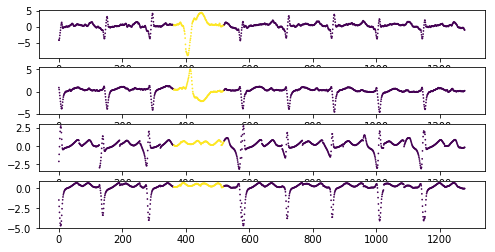

In [0]:
fig = plt.figure(figsize=(8,4)) 
ax1 = fig.add_subplot(4, 1, 1) 
ax2 = fig.add_subplot(4, 1, 2) 
ax3 = fig.add_subplot(4, 1, 3) 
ax4 = fig.add_subplot(4, 1, 4) 

ax1.scatter(torch.arange(len(disp_inputs)), disp_inputs[:,0], c=disp_labels, s=0.5) 
ax2.scatter(torch.arange(len(disp_inputs)), disp_inputs[:,1], c=disp_labels, s=0.5) 
ax3.scatter(torch.arange(len(disp_outputs)), disp_outputs[:,0], c=disp_labels, s=0.5) 
ax4.scatter(torch.arange(len(disp_outputs)), disp_outputs[:,1], c=disp_labels, s=0.5) 

## 5. Report
* Download **'train_gesture.npy'**, and **'test_gesture.npy'**  

>* https://github.com/YongHoYoo/anomaly_tutorial/blob/master/train_gesture.npy
>* https://github.com/YongHoYoo/anomaly_tutorial/blob/master/test_gesture.npy

>* Gesture dataset: The X and Y coordinates of the actor's right hand that are extracted from the video images in which the actor grabs a replica gun from a hip mounted holster, moves it to the target, and returns it to the holster. The anomaly is the region where the actor misses the holster. 

* Train **'train_gesture.npy'** and detect anomaly in **'test_gesture.npy'** (70pt)
* Plot reconstruction errors (20pt)
* Define model using **GRU cell** instead of **LSTM cell** & evaluate the performance (10pt)
>* $z_t = \sigma(W_z x_t + U_z h_{t-1})$
>* $r_t = \sigma (W_r x_t + U_r h_{t-1})$
>* $c_t = tanh(W_c x_t + r_t \cdot (U_c h_{t-1})$)
>* $h_t = (1-z_t) \cdot c_t + z_t \cdot h_{t-1}$

>### Submit: yhyoo@rit.kaist.ac.kr
